In [6]:
import numpy as np
import tensorflow as tf
import random as rn
import sys
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation

np.set_printoptions(threshold=sys.maxsize)


In [7]:
# ## 1. Jittering

# #### Hyperparameters :  sigma = standard devitation (STD) of the noise
def DA_Jitter(X, sigma=0.1):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + myNoise


# ## 2. Scaling

# #### Hyperparameters :  sigma = STD of the zoom-in/out factor
def DA_Scaling(X, sigma=0.05):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1, X.shape[1]))  # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0], 1)), scalingFactor)
    return X * myNoise


# ## 3. Magnitude Warping

# #### Hyperparameters :  sigma = STD of the random knots for generating curves
#
# #### knot = # of knots for the random curves (complexity of the curves)

# "Scaling" can be considered as "applying constant noise to the entire samples" whereas "Jittering" can be considered as "applying different noise to each sample".

# "Magnitude Warping" can be considered as "applying smoothly-varing noise to the entire samples"


## This example using cubic splice is not the best approach to generate random curves.
## You can use other aprroaches, e.g., Gaussian process regression, Bezier curve, etc.
def GenerateRandomCurves(X, sigma=0.1, knot=4):
    xx = (np.ones((X.shape[1], 1)) * (np.arange(0, X.shape[0], (X.shape[0] - 1) / (knot + 1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot + 2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    random_curves = []
    for i in range(X.shape[-1]):
        cs = CubicSpline(xx[:, i], yy[:, i])
        random_curves.append(cs(x_range))
    return np.array(random_curves).transpose()


def DA_MagWarp(X, sigma=0.05):
    return X * GenerateRandomCurves(X, sigma)


# ## 4. Time Warping

# #### Hyperparameters :  sigma = STD of the random knots for generating curves
#
# #### knot = # of knots for the random curves (complexity of the curves)

def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(X, sigma)  # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)  # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    for i in range(X.shape[-1]):
        t_scale = (X.shape[0] - 1) / tt_cum[-1, i]
        tt_cum[:, i] = tt_cum[:, i] * t_scale
    return tt_cum


def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    for i in range(X.shape[-1]):
        X_new[:, i] = np.interp(x_range, tt_new[:, i], X[:, i])
    return X_new


# ## 5. Permutation

# #### Hyperparameters :  nPerm = # of segments to permute
# #### minSegLength = allowable minimum length for each segment

def DA_Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile:
        segs = np.zeros(nPerm + 1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0] - minSegLength, nPerm - 1))
        segs[-1] = X.shape[0]
        if np.min(segs[1:] - segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]]:segs[idx[ii] + 1], :]
        X_new[pp:pp + len(x_temp), :] = x_temp
        pp += len(x_temp)
    return X_new


In [8]:
def plot_graph_original(description, array, ax, function, dim):
    plt.plot(array, color='#CC6677')
    plt.title(description)
    plt.axis(ax)
    plt.xlabel("time - 4 Hz per second")
    plt.ylabel("value")
    plt.savefig('./plots/' + dim + '/' +  function + '.png')
    plt.show()

In [9]:
def plot_graph(description, orig_array, array, ax, function, dim):
    plt.plot(orig_array, color='#CC6677', alpha = 0.5)
    plt.plot(array, color='#117733')
    plt.title(description)
    plt.axis(ax)
    plt.xlabel("time - 4 Hz per second")
    plt.ylabel("value")
    plt.savefig('./plots/' + dim + '/' +  function + '.png')
    plt.show()

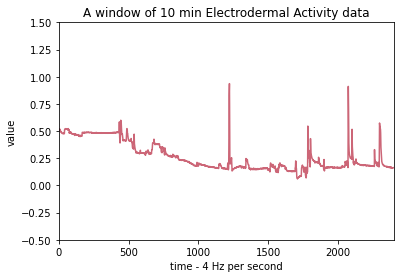

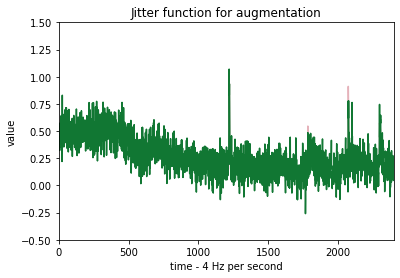

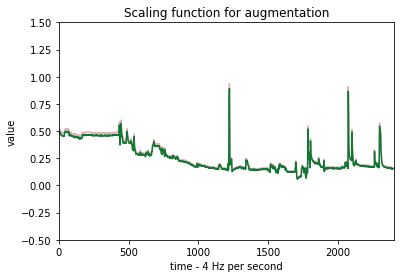

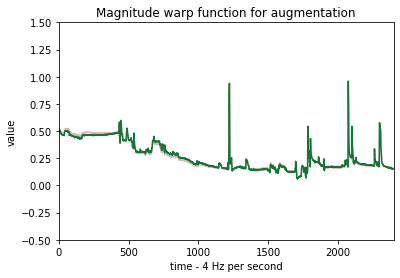

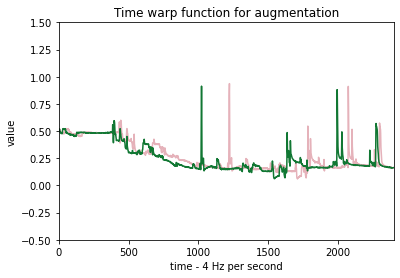

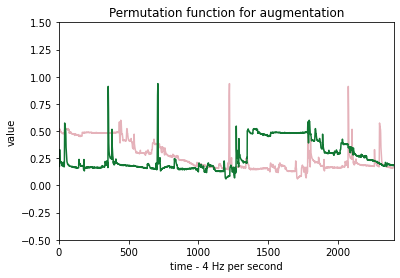

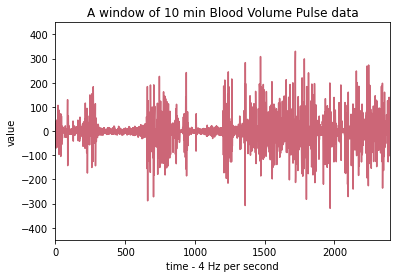

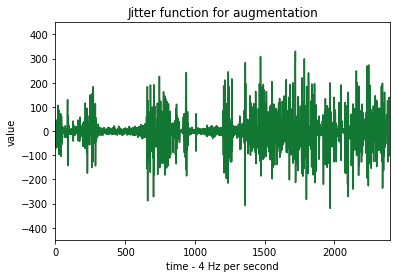

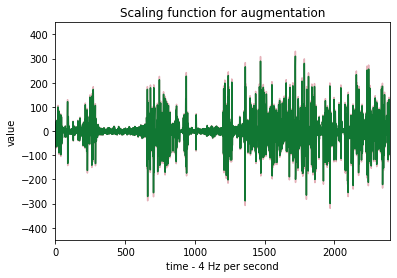

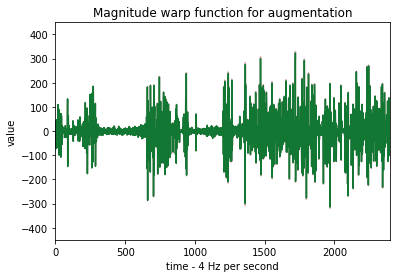

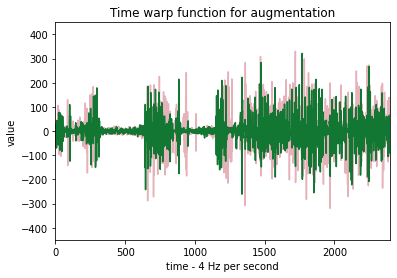

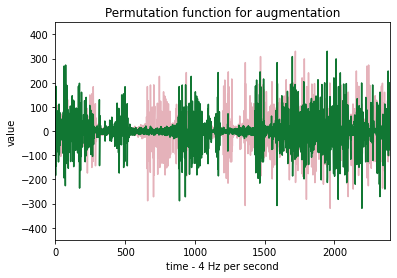

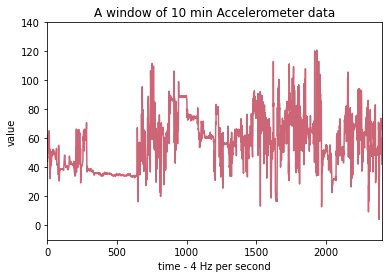

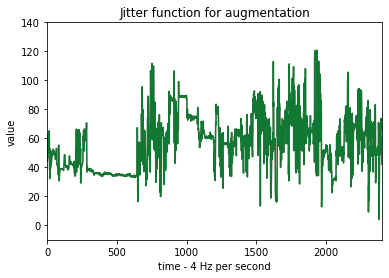

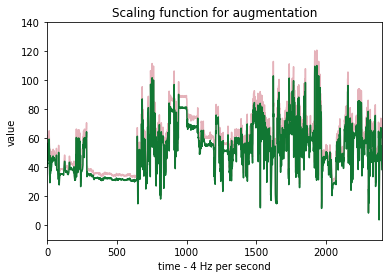

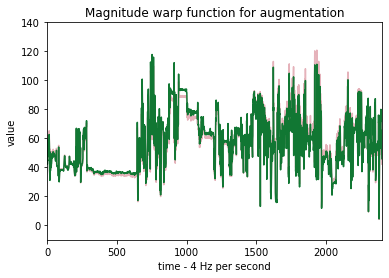

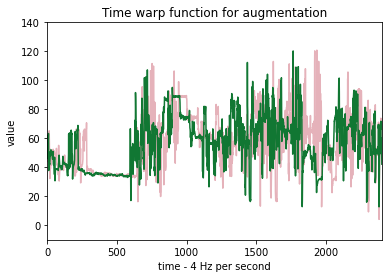

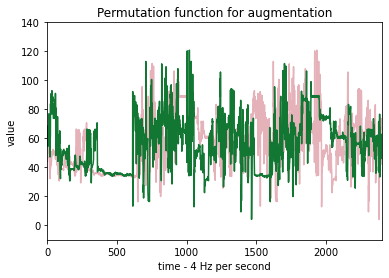

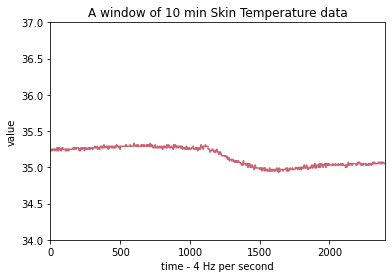

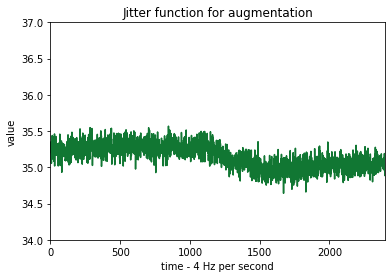

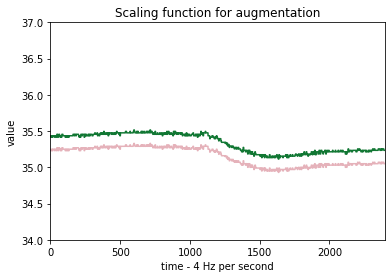

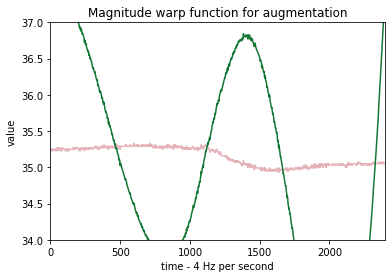

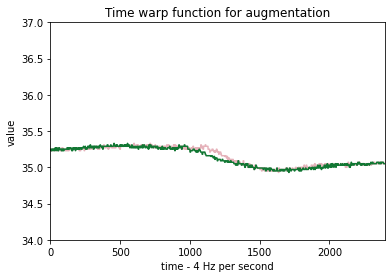

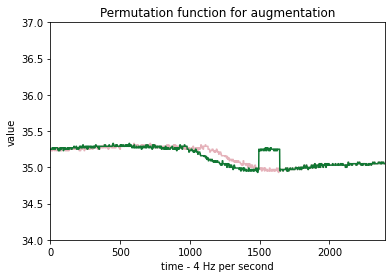

In [10]:
train_set = np.load('train_set_original.npy',  encoding='ASCII')
train_label = np.load('train_label_original.npy',  encoding='ASCII')

techniques = ['original', 'jitter', 'scale', 'magWarp', 'timeWarp', 'permutation']
eda = train_set[0]
bvp = train_set[1]
acc = train_set[2]
tem = train_set[3]


axis_plot = [0,2400,-0.5,1.5]
for function in techniques:
    if function == 'scale':
        array = DA_Scaling(eda.transpose()).transpose()
        plot_graph("Scaling function for augmentation", eda[0], array[0], axis_plot, function, 'eda')
    elif function == 'jitter':
        array = DA_Jitter(eda.transpose()).transpose()
        plot_graph("Jitter function for augmentation", eda[0], array[0], axis_plot, function, 'eda')
    elif function == 'magWarp':
        array = DA_MagWarp(eda.transpose()).transpose()
        plot_graph("Magnitude warp function for augmentation", eda[0], array[0], axis_plot, function, 'eda')
    elif function == 'timeWarp':
        array = DA_TimeWarp(eda.transpose()).transpose()
        plot_graph("Time warp function for augmentation", eda[0], array[0], axis_plot, function, 'eda')
    elif function == 'permutation':
        array = DA_Permutation(eda.transpose()).transpose()
        plot_graph("Permutation function for augmentation", eda[0], array[0], axis_plot, function, 'eda')
    else:
        plot_graph_original("A window of 10 min Electrodermal Activity data", eda[0], axis_plot, function, 'eda')

axis_plot = [0,2400,-450, 450]
for function in techniques:
    if function == 'scale':
        array = DA_Scaling(bvp.transpose()).transpose()
        plot_graph("Scaling function for augmentation", bvp[0], array[0], axis_plot, function, 'bvp')
    elif function == 'jitter':
        array = DA_Jitter(bvp.transpose()).transpose()
        plot_graph("Jitter function for augmentation", bvp[0], array[0], axis_plot, function, 'bvp')
    elif function == 'magWarp':
        array = DA_MagWarp(bvp.transpose()).transpose()
        plot_graph("Magnitude warp function for augmentation", bvp[0], array[0], axis_plot, function, 'bvp')
    elif function == 'timeWarp':
        array = DA_TimeWarp(bvp.transpose()).transpose()
        plot_graph("Time warp function for augmentation", bvp[0], array[0], axis_plot, function, 'bvp')
    elif function == 'permutation':
        array = DA_Permutation(bvp.transpose()).transpose()
        plot_graph("Permutation function for augmentation", bvp[0], array[0], axis_plot, function, 'bvp')
    else:
        plot_graph_original("A window of 10 min Blood Volume Pulse data", bvp[0], axis_plot, function, 'bvp')

axis_plot = [0,2400,-10,140]
for function in techniques:
    if function == 'scale':
        array = DA_Scaling(acc.transpose()).transpose()
        plot_graph("Scaling function for augmentation", acc[0],array[0], axis_plot, function, 'acc')
    elif function == 'jitter':
        array = DA_Jitter(acc.transpose()).transpose()
        plot_graph("Jitter function for augmentation", acc[0],array[0], axis_plot, function, 'acc')
    elif function == 'magWarp':
        array = DA_MagWarp(acc.transpose()).transpose()
        plot_graph("Magnitude warp function for augmentation", acc[0],array[0], axis_plot, function, 'acc')
    elif function == 'timeWarp':
        array = DA_TimeWarp(acc.transpose()).transpose()
        plot_graph("Time warp function for augmentation", acc[0],array[0], axis_plot, function, 'acc')
    elif function == 'permutation':
        array = DA_Permutation(acc.transpose()).transpose()
        plot_graph("Permutation function for augmentation", acc[0],array[0], axis_plot, function, 'acc')
    else:
        plot_graph_original("A window of 10 min Accelerometer data", acc[0], axis_plot, function, 'acc')


axis_plot = [0,2400,34,37]
for function in techniques:
    if function == 'scale':
        array = DA_Scaling(tem.transpose()).transpose()
        plot_graph("Scaling function for augmentation", tem[100],array[100], axis_plot, function, 'tem')
    elif function == 'jitter':
        array = DA_Jitter(tem.transpose()).transpose()
        plot_graph("Jitter function for augmentation", tem[100],array[100], axis_plot, function, 'tem')
    elif function == 'magWarp':
        array = DA_MagWarp(tem.transpose()).transpose()
        plot_graph("Magnitude warp function for augmentation", tem[100],array[100], axis_plot, function, 'tem')
    elif function == 'timeWarp':
        array = DA_TimeWarp(tem.transpose()).transpose()
        plot_graph("Time warp function for augmentation", tem[100],array[100], axis_plot, function, 'tem')
    elif function == 'permutation':
        array = DA_Permutation(tem.transpose()).transpose()
        plot_graph("Permutation function for augmentation",tem[100], array[100], axis_plot, function, 'tem')
    else:
        plot_graph_original("A window of 10 min Skin Temperature data", tem[100], axis_plot, function, 'tem')


